In [5]:
import pandas as pd
import numpy as np
import re

In [6]:
finalized_reviews = pd.read_csv("finalized_reviews.csv")
finalized_reviews.head()

,Unnamed: 0,review_content,Sentiment
0,0,middle school teacher gifted literature value ...,1
1,1,lightning thief admirable kid fantasy,1
2,2,ok,-1
3,3,there resembling spark film,-1
4,4,truly film age darkly comic stuff mistress mis...,1


In [7]:
from sklearn.model_selection import train_test_split
X_data = finalized_reviews[['review_content']]
y_data = finalized_reviews['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size = 0.2, 
                                                    random_state=1, 
                                                    stratify = y_data)
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train, y_train, 
                                                              test_size = 0.2, 
                                                              random_state=1, 
                                                              stratify = y_train)

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)
print('Train/Valid/Test sizes:', y_train.shape[0], y_valid.shape[0], y_test.shape[0])

X_train.shape: (36596, 1)
y_train.shape: (36596,)
X_test.shape: (9150, 1)
y_test.shape: (9150,)
Train/Valid/Test sizes: 36596 7320 9150


In [8]:
# count vectorizer:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
# vectorize X_train and X_test
train_matrix = vec.fit_transform(X_train['review_content'].values.astype('U'))
test_matrix = vec.transform(X_test['review_content'].values.astype('U'))

In [9]:
X_train = train_matrix
X_test = test_matrix
y_train = y_train.astype('int')
y_test = y_test.astype('int')
# print dimensions
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36596, 32922)
(36596,)
(9150, 32922)
(9150,)


In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
random_forest_model = RandomForestClassifier(criterion='entropy', n_estimators=100,
                                random_state=1)
random_forest_model.fit(X_train, y_train)
print(f"Train Accuracy: {random_forest_model.score(X_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {random_forest_model.score(X_test, y_test)*100:0.3f}%")

Train Accuracy: 99.978%
Test Accuracy: 81.727%


# GridSearchCV

In [16]:
rf = RandomForestClassifier(random_state=1)
param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, None],
               'criterion': ['gini', 'entropy'], 
               'n_estimators': [10, 50, 100, 150]}]

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  refit=True,
                  cv=10,
                  n_jobs=None)

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

for i in range(len(gs.cv_results_['mean_test_score'])):
    print(gs.cv_results_['mean_test_score'][i], gs.cv_results_['params'][i]) 

print('Best Params: %s' % gs.best_params_)
print('Test Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100)) # best test accuracy

Best Accuracy: 81.18%
Best Params: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 150}
0.7137118893901855 {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 10}
0.7137118893901855 {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 50}
0.7137118893901855 {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 100}
0.7137118893901855 {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 150}
0.7137118893901855 {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 10}
0.7137118893901855 {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 50}
0.7137118893901855 {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100}
0.7137118893901855 {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 150}
0.7137118893901855 {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 10}
0.7137118893901855 {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 50}
0.7137118893901855 {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100}
0.7137118893901855 {'criterion': 'gini', 'max_de

GridSearch gives a best score, but the test accuracy is not the highest. n_estimator = 100 seems to have higher test accuracy. 

In [17]:
random_forest_model = RandomForestClassifier(criterion='entropy', n_estimators=150,
                                random_state=1)
random_forest_model.fit(X_train, y_train)
print(f"Train Accuracy: {random_forest_model.score(X_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {random_forest_model.score(X_test, y_test)*100:0.3f}%")

Train Accuracy: 99.978%
Test Accuracy: 81.585%


### Try: class_weight='balanced'

In [12]:
random_forest_model = RandomForestClassifier(criterion='entropy', n_estimators=150,
                                random_state=1, class_weight='balanced')
random_forest_model.fit(X_train, y_train)
print(f"Train Accuracy: {random_forest_model.score(X_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {random_forest_model.score(X_test, y_test)*100:0.3f}%") # a higher test accuracy

Train Accuracy: 99.978%
Test Accuracy: 82.098%


# Plots

In [24]:
from time import sleep
from tqdm import tqdm

In [25]:
random_forest_model = RandomForestClassifier(criterion='entropy', n_estimators=100,
                                random_state=1, class_weight='balanced')

pred_train, pred_test = [], []

intervals = np.arange(500, X_train.shape[0] + 1, 1000)

for i in tqdm(intervals):
    random_forest_model.fit(X_train[:i], y_train[:i])
    p_train = random_forest_model.score(X_train[:i], y_train[:i])
    p_test = random_forest_model.score(X_test, y_test)
    pred_train.append(p_train)
    pred_test.append(p_test)

100%|██████████| 37/37 [34:06<00:00, 55.31s/it] 


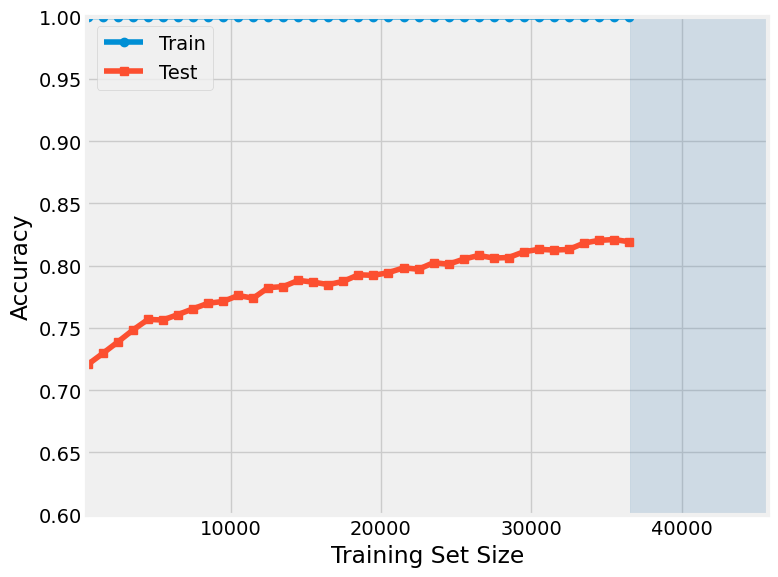

In [27]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=100)
with plt.style.context(('fivethirtyeight')):
    plt.plot(intervals, pred_train, marker='o', label='Train')
    plt.plot(intervals, pred_test, marker='s', label='Test')
    plt.legend(loc='best', numpoints=1)
    plt.xlim([430, X_train.shape[0] + X_test.shape[0]])
    plt.axvspan(X_train.shape[0], 
                X_train.shape[0] + X_test.shape[0], 
                alpha=0.2, 
                color='steelblue')
    plt.ylim([0.6, 1.0])
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    #plt.savefig('figures/model-eval-mnist_0.svg')

In [38]:
random_forest_model.fit(X_train, y_train)
acc_test_na = random_forest_model.score(X_test, y_test)
ci_test_na = 1.96 * np.sqrt((acc_test_na*(1-acc_test_na)) / y_test.shape[0])

test_na_lower = acc_test_na-ci_test_na
test_na_upper = acc_test_na+ci_test_na

print(test_na_lower, test_na_upper)

0.8131283718011992 0.8288388413135548


# Bootstrap Methods

## OOB Bootstrap with Percentile Method

In [ ]:
from mlxtend.evaluate import bootstrap_point632_score
bootstrap_scores = bootstrap_point632_score(random_forest_model, 
                                            X_train, y_train, 
                                            n_splits=200, 
                                            method='oob',
                                            random_seed=1)

bootstrap_oob_mean = np.mean(bootstrap_scores)
print('Mean Bootstrap score', bootstrap_oob_mean)
print('Score Std', np.std(bootstrap_scores))

bootstrap_oob_percentile_lower = np.percentile(bootstrap_scores, 2.5)
bootstrap_oob_percentile_upper = np.percentile(bootstrap_scores, 97.5)
print(bootstrap_oob_percentile_lower, bootstrap_oob_percentile_upper)

## .632 Bootstrap

In [15]:
bootstrap_scores = bootstrap_point632_score(random_forest_model, 
                                            X_train, y_train, 
                                            n_splits=200,
                                            random_seed=1)

bootstrap_632_mean = np.mean(bootstrap_scores)
print('Mean Bootstrap score', bootstrap_632_mean)
print('Score Std', np.std(bootstrap_scores))

bootstrap_632_percentile_lower = np.percentile(bootstrap_scores, 2.5)
bootstrap_632_percentile_upper = np.percentile(bootstrap_scores, 97.5)
print(bootstrap_632_percentile_lower, bootstrap_632_percentile_upper)

KeyboardInterrupt: 

# Confusion Matrix

[[1473 1147]
 [ 502 6028]]


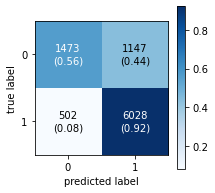

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

pipe = make_pipeline(StandardScaler(with_mean=False), 
                     random_forest_model)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
confmat = confusion_matrix(y_test, y_pred)
print(confmat)

fig, ax = plot_confusion_matrix(conf_mat=confmat,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                figsize=(3, 3))
plt.show()